## 0. Setup

In [1]:
import os


batch_size = 2
threads = 4

# Should point to the root folder of the cropped images, see the tutorial for preparing IXI
dataset_folder = os.path.join(os.path.expanduser('~'), 'data', 'IXI', 'cropped')

## 1. Instantiate the generator

In [2]:
from pyment.data import AsyncNiftiGenerator, NiftiDataset


dataset = NiftiDataset.from_folder(dataset_folder, target='id')

# Set up a preprocessor to normalize the voxel values
preprocessor = lambda x: x/255

generator = AsyncNiftiGenerator(dataset, preprocessor=preprocessor, 
                                batch_size=batch_size, threads=threads)

2021-07-03 15:16:33,503 - WARNING - pyment.data.datasets.nifti_dataset: Skipping IXI051-HH-1328-T1: Missing image
2021-07-03 15:16:33,504 - WARNING - pyment.data.datasets.nifti_dataset: Skipping IXI387-HH-2101-T1: Missing image
2021-07-03 15:16:33,505 - WARNING - pyment.data.datasets.nifti_dataset: Skipping IXI260-HH-1805-T1: Missing image
2021-07-03 15:16:33,505 - WARNING - pyment.data.datasets.nifti_dataset: Skipping IXI538-HH-2411-T1: Missing image
2021-07-03 15:16:33,505 - WARNING - pyment.data.datasets.nifti_dataset: Skipping IXI554-Guys-1068-T1: Missing image
2021-07-03 15:16:33,506 - WARNING - pyment.data.datasets.nifti_dataset: Skipping IXI227-Guys-0813-T1: Missing image
2021-07-03 15:16:33,506 - WARNING - pyment.data.datasets.nifti_dataset: Skipping IXI070-Guys-0767-T1: Missing image
2021-07-03 15:16:33,507 - WARNING - pyment.data.datasets.nifti_dataset: Skipping IXI163-HH-1621-T1: Missing image
2021-07-03 15:16:33,507 - WARNING - pyment.data.datasets.nifti_dataset: Skipping I

## 2. Sanity check the generator

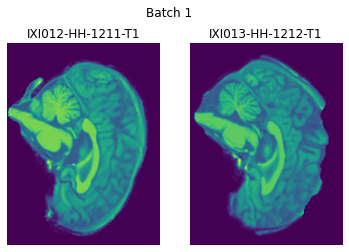

Image batch shape: (2, 167, 212, 160)
Image voxel value range: 0.0-0.78


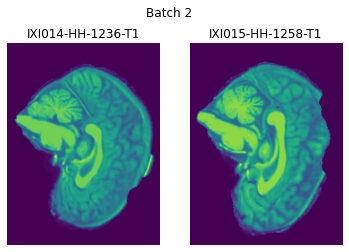

Image batch shape: (2, 167, 212, 160)
Image voxel value range: 0.0-0.61


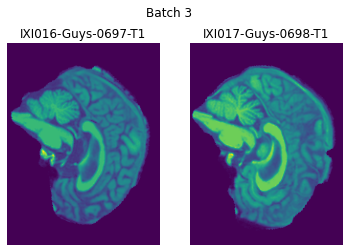

Image batch shape: (2, 167, 212, 160)
Image voxel value range: 0.0-0.72


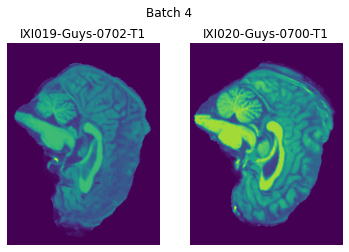

Image batch shape: (2, 167, 212, 160)
Image voxel value range: 0.0-0.75


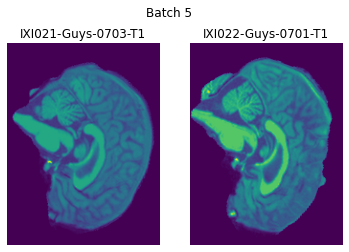

Image batch shape: (2, 167, 212, 160)
Image voxel value range: 0.0-0.8


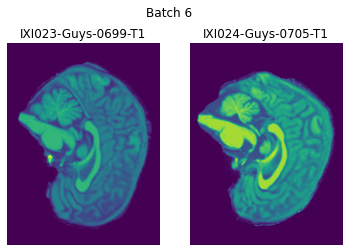

Image batch shape: (2, 167, 212, 160)
Image voxel value range: 0.0-0.73


In [3]:
import matplotlib.pyplot as plt
import numpy as np

batches = 0

for X, y in generator:
    fig, ax = plt.subplots(1, batch_size)
    fig.suptitle(f'Batch {batches+1}')
    
    for i in range(batch_size):
        ax[i].imshow(X[i,83,:,:])
        ax[i].axis('off')
        ax[i].set_title(y[i])
        
    plt.show()
    
    print(f'Image batch shape: {X.shape}')
    print(f'Image voxel value range: {round(np.amin(X), 2)}-{round(np.amax(X), 2)}')
    
    batches += 1
    
    if batches > 5:
        break

## 3. Configure the model

In [4]:
from pyment.models import RegressionSFCN


model = RegressionSFCN(weights='brain_age', include_top=False)

## 4. Generate feature vectors

In [6]:
dataset.target = 'id'

generator.reset()

preds, ids = model.predict(generator, return_labels=True)

100%|██████████| 269/269 [17:04<00:00,  3.81s/it]


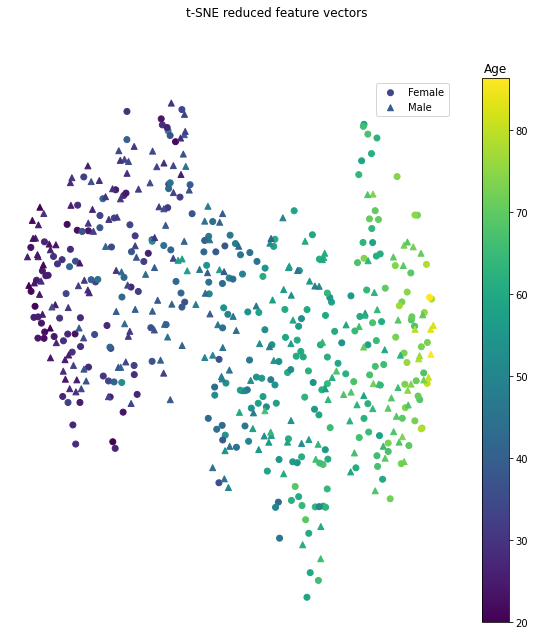

In [26]:
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE


np.random.seed(42)

features = [f'Feature {x}' for x in range(64)]
predictions = pd.DataFrame(preds, index=ids, columns=features)
labels = pd.DataFrame({'age': dataset._labels['age'], 'sex': dataset._labels['sex']}, index=dataset.ids)
df = predictions.join(labels)

tsne = TSNE(n_components=2, perplexity=50, init='pca')
components = tsne.fit_transform(df[features])

female = df['sex'] == 'F'
male = df['sex'] == 'M'

fig = plt.figure(figsize=(10, 10))

fig.suptitle('t-SNE reduced feature vectors')

vmin = np.amin(df['age'])
vmax = np.amax(df['age'])

f = plt.scatter(components[female,0], components[female,1], marker='o', 
                c=df.loc[female, 'age'].values, vmin=vmin, vmax=vmax)
m = plt.scatter(components[male,0], components[male,1], marker='^', 
                c=df.loc[male, 'age'].values, vmin=vmin, vmax=vmax)

clb = plt.colorbar(f)
clb.ax.set_title('Age')

plt.gca().axis('off')

plt.legend([f, m], ['Female', 'Male'])

plt.show()